# Определение возраста покупателей

## Введение

Цель настоящего проекта - построить модель, которая по фотографии определит приблизительный возраст человека. Данные представляют собой набор фотографий людей с указанием возраста. Данные взяты с сайта *ChaLearn Looking at People*.

Условием задачи является добиться значения *MAE* (*mean absolute error*) на тестовой выборке не больше 8.

## План проекта

1) [Проведем исследовательский анализ данных.](#one)

2) [Построим и обучим модель на *GPU*-сервере.](#two)

5) [Анализ обученной модели и общий вывод.](#three)

## Исследовательский анализ данных<a id='one'></a>

Установим необходимые библиотеки:

In [1]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

Загрузим датафрейм с разметкой фотографий:

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')

Посмотрим первые 5 строк датафрейма:

In [3]:
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


Создадим загрузчик данных:

In [4]:
train_datagen = ImageDataGenerator(rescale=1./255)

Извлечем данные:

In [5]:
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.


Построим распределение возраста людей в выборке:

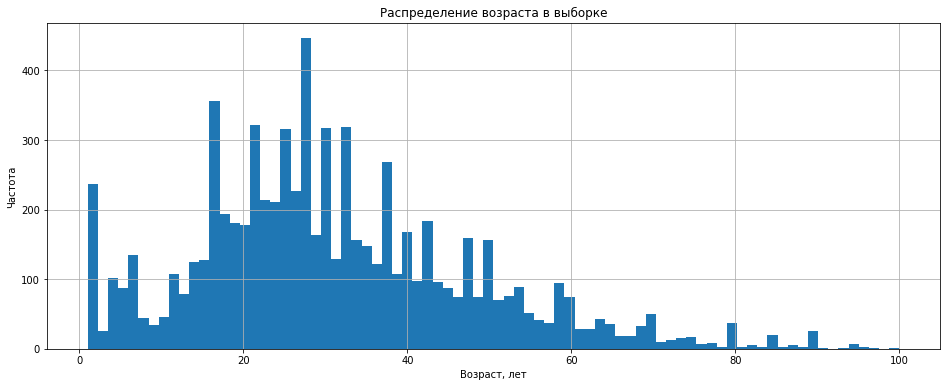

In [6]:
plt.figure(figsize=(16,6))
plt.title('Распределение возраста в выборке')
plt.xlabel('Возраст, лет')
plt.ylabel('Частота')
labels['real_age'].hist(bins=80);

Выведем на экран 10 фотографий:

In [16]:
features, target = next(train_gen_flow)

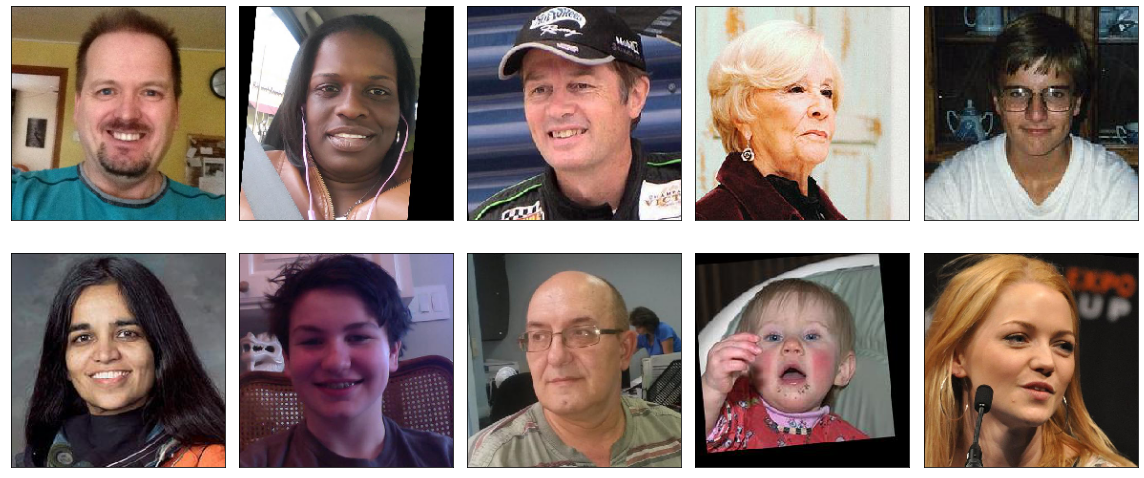

In [19]:
fig = plt.figure(figsize=(16,8))
for i in range(10):
    fig.add_subplot(2, 5, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

## Обучение модели<a id='two'></a>

Код из этого раздела запускался на GPU-сервере, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке.

Код с загрузкой библиотек:

```python
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
```

Функции для загрузки обучающей и отложенной выборки:

```python
def load_train(path):
    
    labels = pd.read_csv(path+'labels.csv')
    
    train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.25)
    
    train_gen_flow = train_datagen.flow_from_dataframe(dataframe=labels,
                                                       directory=path+'final_files',
                                                       x_col='file_name',
                                                       y_col='real_age',
                                                       target_size=(224, 224),
                                                       batch_size=16,
                                                       class_mode='raw',
                                                       subset='training',
                                                       seed=12345) 

    return train_gen_flow
    
def load_test(path):
    
    labels = pd.read_csv(path+'labels.csv')
    
    test_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.25)
    
    test_gen_flow = test_datagen.flow_from_dataframe(dataframe=labels,
                                                     directory=path+'final_files',
                                                     x_col='file_name',
                                                     y_col='real_age',
                                                     target_size=(224, 224),
                                                     batch_size=16,
                                                     class_mode='raw',
                                                     subset='validation',
                                                     seed=12345) 

    return test_gen_flow
```

Функция для создания модели:

```python
def create_model(input_shape):
    
    backbone = ResNet50(input_shape=input_shape,
                        weights='imagenet',
                        include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D(input_shape=input_shape))
    model.add(Dense(20, activation='relu')) 
    model.add(Dense(1, activation='relu')) 
    
    optimizer = Adam(learning_rate=0.0001)
    
    model.compile(loss='mse', optimizer=optimizer, metrics=['mae'])
    
    return model
```

Функция для обучения модели:

```python
def train_model(model, train_gen_flow, test_gen_flow, batch_size=None, epochs=5,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_gen_flow)
    if validation_steps is None:
        validation_steps = len(test_gen_flow)

    model.fit(train_gen_flow,
              validation_data=test_gen_flow,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)

    return model
```

Вывод:

```

Found 5694 validated image filenames.

Found 1897 validated image filenames.

Train for 356 steps, validate for 119 steps

Epoch 1/5

356/356 - 65s - loss: 215.1766 - mae: 10.4877 - val_loss: 491.3314 - val_mae: 17.0459

Epoch 2/5

356/356 - 37s - loss: 69.8833 - mae: 6.3600 - val_loss: 453.5304 - val_mae: 18.3257

Epoch 3/5

356/356 - 38s - loss: 38.1222 - mae: 4.7213 - val_loss: 81.5446 - val_mae: 6.6302

Epoch 4/5

356/356 - 38s - loss: 24.1028 - mae: 3.7514 - val_loss: 76.4825 - val_mae: 6.7449

Epoch 5/5

356/356 - 39s - loss: 17.0239 - mae: 3.1911 - val_loss: 71.9246 - val_mae: 6.601

```

## Анализ обученной модели<a id='three'></a>

Модель достигла небходимого значения *MAE* на тестовой выборке (не более 8) уже на третьей эпохе. Стоит отметить, что модель переобучилась (значение *MAE* на обучающей выборке практически в 2 раза меньше, чем на тестовой) из-за большого числа слоев нейросети.

Построенная модель глубокого обучения позволяет предсказывать возраст человека на фото с средней абсолютной ошибкой (*MAE*) в 6,6 лет.